# Apply Perturbations to Tumor-Specific Genes in SCC

**helical-ai:** Utilize the workflow to target previously-reported tumor-specific genes in squamous
cell carcinoma (SCC) populations which contribute to pathology. Simulate
perturbations and process the resulting data using the GeneFormer_V2_Cancer model
to embed the perturbation effects into a biologically informed latent space.

**Titouan:** This step took me a bit more time as the task seemed somewhat open-ended. I ultimately chose to import the count data from the SCC Dataset (PMC7391009), apply my in-silico perturbation method to tumor-related genes, and embed the perturbed and unperturbed results for further analysis in step 3. I also faced a few issues stemming from working on my laptop, mainly issues with memory and the slow embedding process.

## 1) Imports & seed

In [34]:
import numpy as np
import gzip
import requests
import anndata as ad
import pandas as pd
import random
import scanpy as sc
from anndata import AnnData

seed = 42
np.random.seed(seed)

## 2) Downloading data & processing data

I took the count data from the experiments on SCC from the PMC7391009 paper.

### 2.1) Downloading and extracting

In [35]:
filename = "SCCcounts.txt.gz"
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE144nnn/GSE144236/suppl/GSE144236%5FcSCC%5Fcounts%2Etxt%2Egz"

print(f"Downloading {filename}...")
response = requests.get(url)

if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Downloaded: {filename}")
else:
    print(f"Failed to download {filename}. HTTP status code: {response.status_code}")

# Uncompress
filename_uncompressed = filename.split(".")[0] + ".txt"
with gzip.open(filename, 'rt') as infile:
    with open(filename_uncompressed, 'w') as outfile:
        for line in infile:
            outfile.write(line)
    print(f"Uncompressed: {filename_uncompressed}")

Downloaded: SCCcounts.txt.gz
Uncompressed: SCCcounts.txt


### 2.2) .txt to AnnData

Since we downloaded raw count data (i.e., the number of reads for each gene in each sample), we now need to format this data into an AnnData object. I built a simple parser that reads a specified number of samples (columns) in a memory-efficient manner. It also selects random columns without repetition to avoid always using the first N samples.

In [36]:
chunk_size = 5000
N = 5000 # I don't have enough memory to load every sample
processed_chunks = []
gene_names = []
obs_names = []
patient = []
tissue = []
total = 0
total_lines = sum(1 for _ in open(filename_uncompressed, 'rb'))

with open(filename_uncompressed, "r") as file:
    # Read the header (column/sample names)
    header = file.readline().strip().split("\t")
    n_samples = len(header)
    samples_idx = np.random.choice(np.arange(0, n_samples), size=N, replace=False)
    
    patient = file.readline().strip().split("\t")
    patient = [patient[i + 1] for i in samples_idx]
    patient = list(map(int, patient))
    
    tissue = file.readline().strip().split("\t")
    tissue = [tissue[i + 1] for i in samples_idx]
    tissue = list(map(int, tissue))
    
    obs_names = [header[i] for i in samples_idx]

    processed_chunks = []
    gene_names = []
    total = 0

    while True:
        # Read the next chunk of rows
        chunk = []
        chunk_gene_names = []
        for _ in range(chunk_size):
            line = file.readline()
            if not line:
                break
            # Split the line into gene name and expression values
            row = line.strip().split("\t")
            chunk_gene_names.append(row[0])  # First value is the gene name
            chunk.append([row[i + 1] for i in samples_idx])  # Remaining values are expression data
            
        # If no more data, break the loop
        if not chunk:
            break

        chunk_array = np.array(chunk, dtype=int)

        # Append chunk
        processed_chunks.append(chunk_array)
        gene_names.extend(chunk_gene_names)

        total += len(chunk)
        if total % 5000 == 0:
            print(f"Processed {total}/{total_lines} rows")

print(f"Processed {total}/{total_lines} rows -> finished!")

/tmp/ipykernel_131/405662546.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='SCCcounts.txt'>
  total_lines = sum(1 for _ in open(filename_uncompressed, 'rb'))


Processed 5000/32741 rows
Processed 10000/32741 rows
Processed 15000/32741 rows
Processed 20000/32741 rows
Processed 25000/32741 rows
Processed 30000/32741 rows
Processed 32738/32741 rows -> finished!


In [37]:
# Combine all processed chunks into a single NumPy array
final_data = np.vstack(processed_chunks)
final_data = final_data.T

# Create an AnnData object
adata = AnnData(X=final_data)

gene_names = [gene.replace('"', '') for gene in gene_names]
obs_names = [obs.replace('"', '') for obs in obs_names]
adata.var.index = gene_names
adata.var["gene_names"] = gene_names
adata.obs["samples"] = obs_names
adata.obs["patient"] = patient
adata.obs["tissue"] = tissue
adata

AnnData object with n_obs × n_vars = 500 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

### 2.3) Looking at our AnnData object

In [38]:
adata.obs['samples']

0       P5_Tumor_AAAGATGTCCTCCTAG
1      P2_Normal_TGGGCGTTCCGTCATC
2      P10_Tumor_CTTGGCTTCTCTAAGG
3       P4_Tumor_CGAGAAGCATCCTAGA
4      P9_Normal_ACTATCTTCGATCCCT
                  ...            
495     P9_Tumor_CCTTCGAGTTCTGTTT
496    P9_Normal_CTGAAGTGTGCGCTTG
497    P9_Normal_GATCGCGCAGTAAGAT
498     P4_Tumor_CTCTGGTCAGGATTGG
499     P5_Tumor_ATAGACCTCGGAAACG
Name: samples, Length: 500, dtype: object

In [39]:
adata.obs['tissue']

0      1
1      0
2      1
3      1
4      0
      ..
495    1
496    0
497    0
498    1
499    1
Name: tissue, Length: 500, dtype: int64

## 3) Simulating perturbations

### 3.1) Importing step 1

In [40]:
import nbimporter # I don't recommend using this module, this is used only to keep everything in notebooks
from step1_insilico_perturbation import perturb_genes_counts

### 3.2) Identifying genes of interest

I couldn't find the tumor specific genes in the paper so I decided to just extract them myself from the raw counts data using differential expression analysis

In [41]:
adata_pert = adata.copy() # Making a copy because we still need the raw counts for GeneFormer

In [42]:
adata_pert.var_names

Index(['RP11-34P13.7', 'AL627309.1', 'AP006222.2', 'RP4-669L17.10',
       'RP11-206L10.3', 'RP11-206L10.2', 'RP11-206L10.9', 'FAM87B',
       'LINC00115', 'FAM41C',
       ...
       'BX072566.1', 'KIR2DL2', 'KIR3DL2.1', 'AL590523.1', 'CT476828.1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [43]:
# Filter out genes with low counts across spots
sc.pp.filter_genes(adata_pert, min_cells=3)

# Normalize the data (Scanpy will handle size factor normalization)
sc.pp.normalize_total(adata_pert, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata_pert)
adata_pert

AnnData object with n_obs × n_vars = 500 × 15226
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names', 'n_cells'
    uns: 'log1p'

In [44]:
adata_pert.obs['tissue'] = pd.Categorical(adata_pert.obs['tissue'], categories=[0, 1])

# Map the integers to meaningful labels (e.g., 'healthy' and 'tumor')
category_mapping = {0: 'healthy', 1: 'tumor'}
adata_pert.obs['tissue'] = adata_pert.obs['tissue'].map(category_mapping)

# Convert back to categorical with labeled categories
adata_pert.obs['tissue'] = pd.Categorical(adata_pert.obs['tissue'], categories=['healthy', 'tumor'])
adata_pert

AnnData object with n_obs × n_vars = 500 × 15226
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names', 'n_cells'
    uns: 'log1p'

In [45]:
sc.tl.rank_genes_groups(adata_pert, groupby='tissue', method='t-test')

In [46]:
# Perform differential expression analysis using t-test
sc.tl.rank_genes_groups(adata_pert, groupby='tissue', method='t-test')

# Extract the results for the top N genes for each group
top_genes = adata_pert.uns['rank_genes_groups']['names']  # Get the gene names for all groups

N = 1000 # top 1000 genes (chosen arbitrarily)

# Extract the top N genes from each group
top_genes_N = {group: top_genes[group][:N] for group in top_genes.dtype.names}

# Extract the log fold change for each gene
log_fold_changes = adata_pert.uns['rank_genes_groups']['logfoldchanges']

# Extract the p-values for the genes
p_values = adata_pert.uns['rank_genes_groups']['pvals']

# Determine whether each gene is over- or under-expressed based on log-fold change
# log-fold change = log2(expressionA/expressionB) so log2 > 0: over-expressed and log2 < 0: underexpressed
# this ends up being useless because they end up being all over-expressed due to how scipy selects the genes
expression_status = {group: ['over-expressed' if fc > 0 else 'under-expressed' for fc in log_fold_changes[group][:N]] 
                     for group in log_fold_changes.dtype.names}

# Combine the gene names, log fold change, p-values, and expression status into a dataframe
top_genes_info = []
for group in top_genes_N:
    for gene, fc, p_val, status in zip(top_genes_N[group], log_fold_changes[group][:N], p_values[group][:N], expression_status[group]):
        top_genes_info.append({
            'Group': group,
            'Gene': gene,
            'Log Fold Change': fc,
            'P-Value': p_val,
            'Expression Status': status
        })

top_genes_df = pd.DataFrame(top_genes_info)

# Show the result
print(top_genes_df)

        Group     Gene  Log Fold Change       P-Value Expression Status
0     healthy     EGR1         2.052995  1.279296e-27    over-expressed
1     healthy    CCL27         3.336983  2.668639e-25    over-expressed
2     healthy    KRT10         2.776552  6.579038e-26    over-expressed
3     healthy     SIK1         2.299069  5.964742e-24    over-expressed
4     healthy  ZFP36L2         1.714001  3.487831e-24    over-expressed
...       ...      ...              ...           ...               ...
1995    tumor    COPB1         0.703079  1.931079e-03    over-expressed
1996    tumor     TTC1         0.621587  1.933788e-03    over-expressed
1997    tumor      ATM         1.119227  1.951042e-03    over-expressed
1998    tumor  LDLRAD4         1.586843  1.976501e-03    over-expressed
1999    tumor   PI4K2A         1.579913  1.995449e-03    over-expressed

[2000 rows x 5 columns]


/opt/conda/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 15226 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


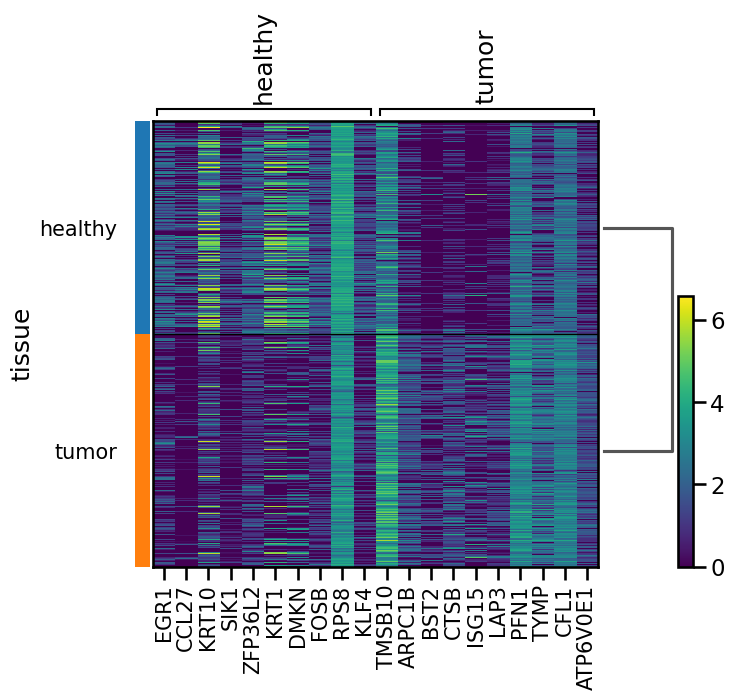

In [47]:
sc.pl.rank_genes_groups_heatmap(adata_pert, n_genes=10, groupby='tissue', show=True)

In [48]:
healthy_genes = top_genes_N.get('healthy', [])
print(healthy_genes[:100])
tumor_genes = top_genes_N.get('tumor', [])
print(tumor_genes[:100])

['EGR1' 'CCL27' 'KRT10' 'SIK1' 'ZFP36L2' 'KRT1' 'DMKN' 'FOSB' 'RPS8'
 'KLF4' 'RPL31' 'NRARP' 'RORA' 'MYC' 'TPPP3' 'KLF5' 'ZFP36L1' 'ZFP36'
 'CD55' 'LMNA' 'RPLP1' 'IRF6' 'SEPP1' 'DSP' 'SLC38A2' 'RPL36A' 'ID1'
 'PKP1' 'JUNB' 'TRIM29' 'JUP' 'RPS25' 'CDHR1' 'GATA3' 'KLK11' 'RPL26'
 'NR4A1' 'DSC3' 'NEAT1' 'LGALS7B' 'CAPNS2' 'RPL37A' 'ATF3' 'DSG1' 'PALMD'
 'LGALS7' 'EGFR' 'RPLP2' 'TOB1' 'GATM' 'FGFR3' 'RPS4X' 'LDLR' 'MT1X'
 'RPS12' 'EPHA2' 'ZC3H12A' 'NFIB' 'RPS6' 'GSTM3' 'FOS' 'DAPL1' 'RPS29'
 'TMEM45A' 'RPL9' 'RPL34' 'RPL38' 'LY6D' 'RPL37' 'APOE' 'HOPX' 'RPS11'
 'LYPD3' 'PER1' 'RPL13' 'EIF1' 'PERP' 'PLK2' 'TNFRSF19' 'RPS18' 'EZR'
 'KCNK7' 'H3F3B' 'KRTDAP' 'AQP3' 'NFIX' 'FAM83G' 'SNHG8' 'IRF2BP2'
 'BAIAP2' 'RPS21' 'EMP1' 'RPS13' 'FGFBP1' 'RPS27' 'FBXW7' 'MT-ND3' 'CYR61'
 'MIDN' 'RPL36']
['TMSB10' 'ARPC1B' 'BST2' 'CTSB' 'ISG15' 'LAP3' 'PFN1' 'TYMP' 'CFL1'
 'ATP6V0E1' 'FTL' 'PRELID1' 'ACTB' 'LGALS1' 'LY6E' 'SAT1' 'TPM3' 'CTSC'
 'C1QB' 'MYL12A' 'PSME2' 'CAP1' 'RHOA' 'COTL1' 'GSTO1' 'FAM49B' 'CY

In [49]:
del adata_pert # for memory

### 3.3) Splitting the data

In [50]:
adata_tumor = adata[adata.obs['tissue'] == 1].copy()
adata_tumor

AnnData object with n_obs × n_vars = 261 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

In [51]:
adata_healthy = adata[adata.obs['tissue'] == 0].copy()
adata_healthy

AnnData object with n_obs × n_vars = 239 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

In [52]:
del adata

### 3.4) Simulating knock-up of tumor-specific genes and knock-down of healthy genes in healthy cells

Let's see if we can 'create' tumor cells from healthy cells by only touching the genes we believe contribute to the pathology. We'll later see how this looks in the embeddings.

In [56]:
fold_change = 0.9

In [54]:
perturbed_healthy_adata = perturb_genes_counts(adata_healthy.copy(), "gene_names", tumor_genes, "knock-up", fold_change)
perturbed_healthy_adata = perturb_genes_counts(adata_healthy.copy(), "gene_names", healthy_genes, "knock-down", fold_change)
perturbed_healthy_adata.obs['tissue'] = 2 # Set a tag for latter (0: healthy, 1: tumor, 2: healthy_knock-up, 3: tumor_knock-down)
perturbed_healthy_adata.obs.index = perturbed_healthy_adata.obs.index + "_MODIFIED"
perturbed_healthy_adata

AnnData object with n_obs × n_vars = 239 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

### 3.5) Simulating knock-down of tumor-specific genes in cancerous cells

See above

In [55]:
perturbed_tumor_adata = perturb_genes_counts(adata_tumor.copy(), "gene_names", healthy_genes, "knock-up", fold_change)
perturbed_tumor_adata = perturb_genes_counts(adata_tumor.copy(), "gene_names", tumor_genes, "knock-down", fold_change)
perturbed_tumor_adata.obs['tissue'] = 3 # Set a tag for latter (0: healthy, 1: tumor, 2: healthy_knock-up, 3: tumor_knock-down)
perturbed_tumor_adata.obs.index = perturbed_tumor_adata.obs.index + "_MODIFIED"
perturbed_tumor_adata

AnnData object with n_obs × n_vars = 261 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

### 3.6) Putting it all back together

In [57]:
adata_combined = ad.concat([adata_tumor, adata_healthy, perturbed_healthy_adata, perturbed_tumor_adata], join='outer', merge='same') 
adata_combined

AnnData object with n_obs × n_vars = 1000 × 32738
    obs: 'samples', 'patient', 'tissue'
    var: 'gene_names'

In [58]:
del adata_tumor
del adata_healthy
del perturbed_healthy_adata
del perturbed_tumor_adata

## 4) Checkpoint

In [59]:
def save_anndata(adata: AnnData, file_path: str):
    """
    Saves an AnnData object to a specified file path.
    
    Args:
        adata (AnnData): The AnnData object to save.
        file_path (str): Path to save the `.h5ad` file.
    """
    try:
        adata.write(file_path)
        print(f"AnnData object successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving AnnData object: {e}")

file_path = "checkpoint.h5ad"
save_anndata(adata_combined, file_path)

... storing 'samples' as categorical


AnnData object successfully saved to checkpoint.h5ad


## 5) Embedding

### 5.1) Imports

In [60]:
from helical import Geneformer, GeneformerConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=10, device=device)
geneformer = Geneformer(configurer=model_config)

INFO:helical.utils.downloader:File: '/home/jovyan/.cache/helical/models/geneformer/v1/gene_median_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: '/home/jovyan/.cache/helical/models/geneformer/v1/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File: '/home/jovyan/.cache/helical/models/geneformer/v1/token_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: '/home/jovyan/.cache/helical/models/geneformer/v1/token_dictionary.pkl'
INFO:helical.utils.downloader:File: '/home/jovyan/.cache/helical/models/geneformer/v1/ensembl_mapping_dict.pkl' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: '/home/jovyan/.cache/helical/models/geneformer/v1/ensembl_mapping_dict.pkl'
INFO:helical.utils.downloader:File: '/home/jovyan/.cache/helical/models/geneformer/v1/gf-12L-30M-i2048/c

### 5.2) Conversion I need to do to make everything work

In [61]:
import scipy.sparse as sp

# Convert adata.X to a sparse CSR matrix with dtype=float64
if not sp.issparse(adata_combined.X):  # Check if it's already sparse
    adata_combined.X = sp.csr_matrix(adata_combined.X, dtype=np.float64)

### 5.3) Processing data & Embedding

In [62]:
dataset = geneformer.process_data(adata_combined, gene_names="gene_names") # Maybe seperate MODIFIED from the rest
dataset

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/jovyan/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 19313 genes to Ensembl IDs from a total of 32738 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 1000 × 32738
    obs: 'samples', 'patient', 'tissue', 'total_counts'
    var: 'gene_names', 'ensembl_id', 'gene_ids_collapsed' has no column attribute 'filter_pass'; tokenizing all cells.
INFO:helical.models.geneformer.geneformer_tokenizer:Creating dataset.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'length'],
    num_rows: 1000
})

In [63]:
dataset = dataset.add_column("tissue", adata_combined.obs['tissue'].tolist())
dataset = dataset.add_column("patient", adata_combined.obs['patient'].tolist())
dataset

Dataset({
    features: ['input_ids', 'length', 'tissue', 'patient'],
    num_rows: 1000
})

In [64]:
N = 1000  # Number of rows to sample because I don't have enough time to embedded them all
sampled_dataset = dataset.shuffle(seed=seed).select(range(N))
embeddings = geneformer.get_embeddings(sampled_dataset)
embeddings

INFO:helical.models.geneformer.model:Inference started:


  0%|          | 0/100 [00:00<?, ?it/s]

array([[-0.00966178,  0.00028845,  0.05551311, ..., -0.03750867,
         0.02094728, -0.0534763 ],
       [-0.00188298, -0.00192133,  0.07942488, ..., -0.00246671,
        -0.00121853, -0.03497089],
       [-0.01936999,  0.01553321,  0.07892258, ..., -0.01176252,
         0.01961049, -0.0402434 ],
       ...,
       [-0.02025982,  0.0017828 ,  0.0498505 , ..., -0.01916908,
         0.0106148 , -0.0446007 ],
       [ 0.00053532,  0.01570459,  0.08112805, ..., -0.01300089,
        -0.01150124, -0.03836003],
       [-0.04217244, -0.00798907,  0.06208811, ..., -0.01174584,
        -0.02724068, -0.02172413]], dtype=float32)

## 6) Saving embeddings to a file

In [65]:
np.save("embeddings_full.npy", embeddings)

In [66]:
tissue_df = pd.DataFrame(sampled_dataset['tissue'], columns=["tissue"])
tissue_df.to_csv("embedding_tissue_info.csv", index=True)
tissue_df

,tissue
0,3
1,3
2,3
3,3
4,1
...,...
995,2
996,2
997,3
998,3


In [67]:
patient_df = pd.DataFrame(sampled_dataset['patient'], columns=["patient"])
patient_df.to_csv("embedding_patient_info.csv", index=True)
patient_df

,patient
0,10
1,8
2,6
3,4
4,7
...,...
995,9
996,6
997,6
998,4


"embedding_full" contains a complete set of embedded samples, allowing for the study of shifts caused by perturbation. In contrast, "embedding" includes a larger set of samples, but it is not reciprocal—meaning not all samples have both their shifted and unshifted counterparts in the dataset.